In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline # Nos ayudará a automatizar todo
from sklearn.model_selection import GridSearchCV # Nos ayudará a realizar cross-validation
#from sklearn.ensemble import RandomForestClassifier # Modelo de Random Forest
from sklearn.metrics import classification_report, accuracy_score # Métricas de precisión y performance
from sklearn.model_selection import train_test_split

# Configuration para viz
plt.rcParams["figure.figsize"] = (10,6)

# Random Forest Classification

En este ejemplo comparamos una regresión logística con un Random Forest. Veremos como preparar y ejecutar ambos modelos.

Vamos a utilizar datos de la Universidad de California sobre ingresos de las personas. El data tiene estos campos: 


- age:	Age of the Person
- workclass:	The type of employment of the person
- education:	Education level of the person
- marital_status:	If the person if married or not
- Occupation:	What type of jobs does the person do
- relationship:	Type of relationship of the person
- race:	Ethinicity of the person
- gender:	Gender of the person
- hours_per_week:	Average hours worked per week
- native_country:	Country of origin
- fnlwgt (final weight): Weighted avg that the US government assigns to a combination of demographic variables as gender, race, amongst other factors.
- income: if income is more than 50K a year.

Vemos de inmediato que tenemos variables ordinales, categóricas y continuas. Un interesante problema de análisis. 

Nos enfocaremos en predecir si una persona gana más de 50K en un año (greater_than_50K). Por lo que será una clasificación binaria. Para ello crearemos la variable inicialmente.

In [2]:
# Cargamos datos
data = pd.read_csv('../../DATA/adult.csv')
data.head()
# Procesos iniciales.
data.columns = [c.replace('.', '_') for c in data.columns]
# Reemplazamos los ? por nulos.
data.replace("?", np.nan, inplace=True)
# transformamos la variable objetivo de forma binaria para simplicidad
data['income'] = [1 if v == '>50K' else 0 for v in data.income.values]



In [3]:
# Vemos data types y nulos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  31978 non-null  object
 14  income          32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


In [4]:
# En este ejercicio no vamos a imputar datos nulos, solo trabajaremos con lo que tenemos lleno
data = data.dropna()

# EDA

Exploración de datos inicial. Veamos algunas de las variables principales 

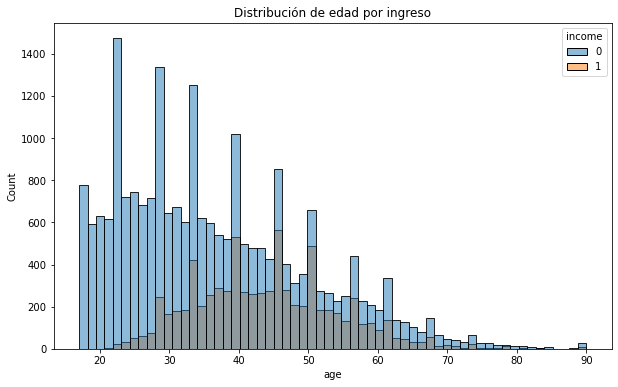

In [5]:
sns.histplot(
    data=data,
    x='age',
    hue="income",
)
plt.title('Distribución de edad por ingreso')
plt.show()

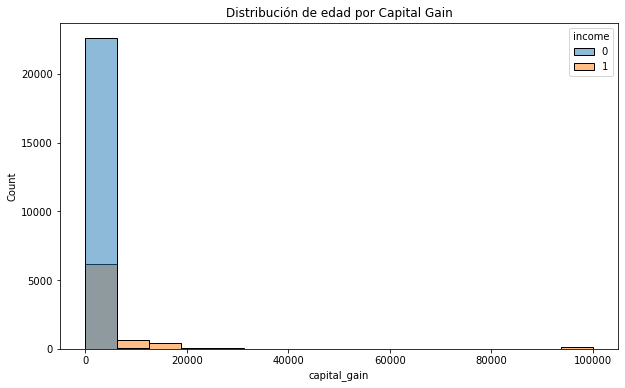

In [6]:
sns.histplot(
    data=data,
    x='capital_gain',
    hue="income",
)
plt.title('Distribución de edad por Capital Gain')
plt.show()

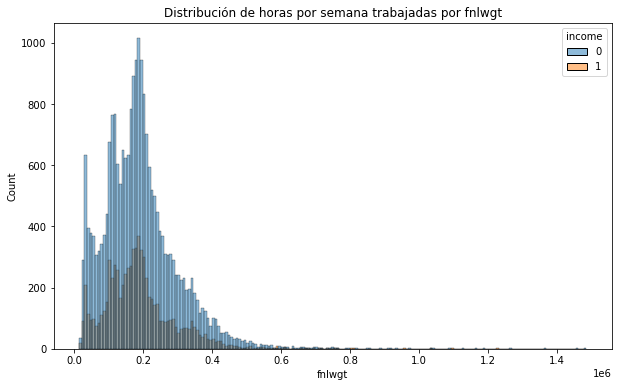

In [7]:
sns.histplot(
    data=data,
    x='fnlwgt',
    hue="income",
)
plt.title('Distribución de horas por semana trabajadas por fnlwgt')
plt.show()

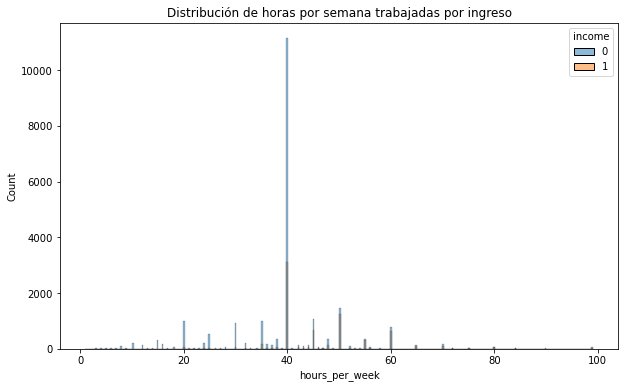

In [8]:
sns.histplot(
    data=data,
    x='hours_per_week',
    hue="income",
)
plt.title('Distribución de horas por semana trabajadas por ingreso')
plt.show()

Este gráfico no es muy informativo, pongamos un límite a la distribución 



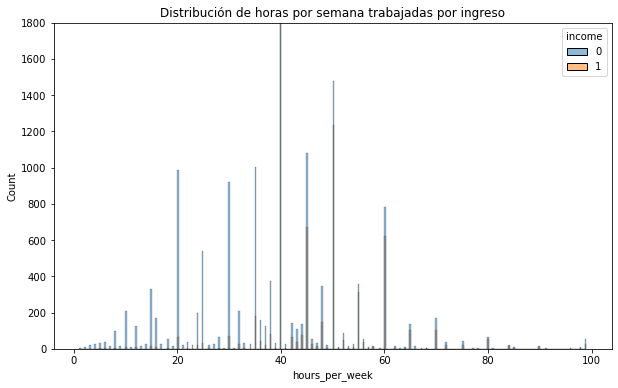

In [9]:
sns.histplot(
    data=data,
    x='hours_per_week',
    hue="income",
)
plt.title('Distribución de horas por semana trabajadas por ingreso')
plt.ylim(0, 1800)
plt.show()

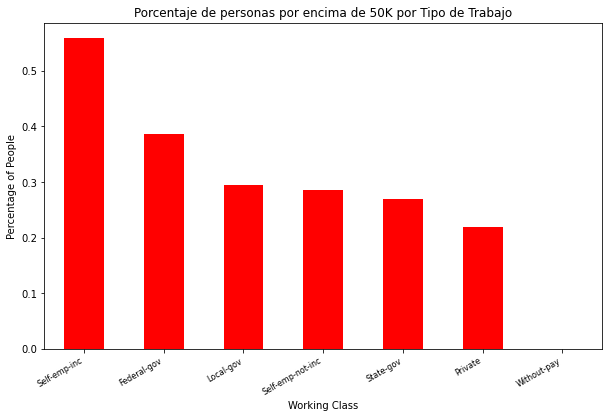

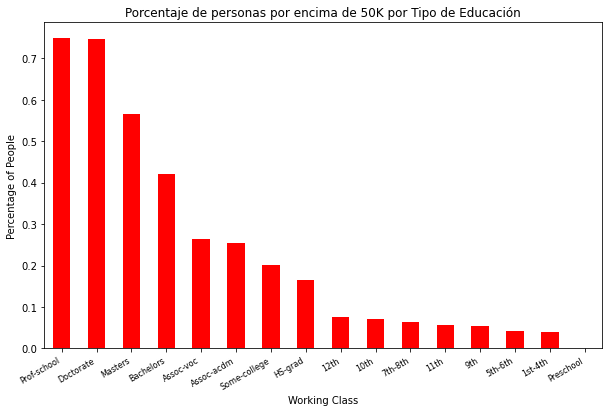

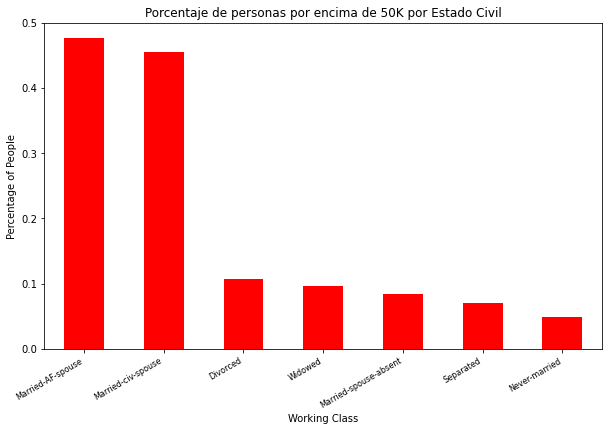

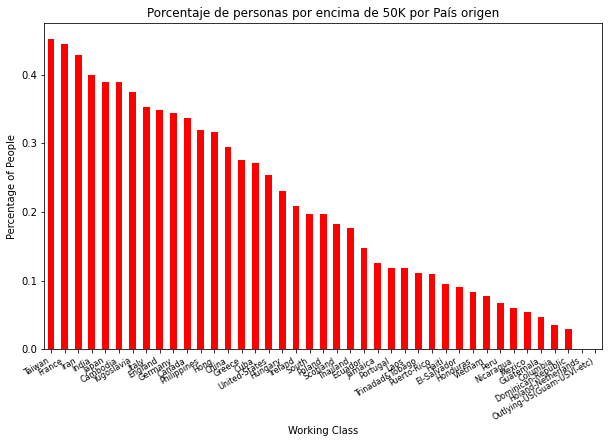

In [10]:
# Relación entre ingreso y trabajo
dist_data = pd.concat(
    [
        data[data.income == 1].groupby('workclass').workclass.count(),
        data[data.income == 0].groupby('workclass').workclass.count()
    ],
    axis=1
)

dist_data.columns = ['wk_class_gt50','wk_class_lt50']

dist_data_final = dist_data.wk_class_gt50 / (dist_data.wk_class_lt50 + dist_data.wk_class_gt50 )

dist_data_final.sort_values(inplace=True,ascending=False)
ax = dist_data_final.plot(kind = 'bar', color = 'r', y='Percentage')
ax.set_xticklabels(dist_data_final.index, rotation=30, fontsize=8, ha='right')
ax.set_xlabel('Working Class')
ax.set_ylabel('Percentage of People')
plt.title("Porcentaje de personas por encima de 50K por Tipo de Trabajo")
plt.show()

# Lo mismo para educación 
dist_data = pd.concat(
    [
        data[data.income == 1].groupby('education').workclass.count(),
        data[data.income == 0].groupby('education').workclass.count()
    ],
    axis=1
)

dist_data.columns = ['wk_class_gt50','wk_class_lt50']

dist_data_final = dist_data.wk_class_gt50 / (dist_data.wk_class_lt50 + dist_data.wk_class_gt50 )

dist_data_final.sort_values(inplace=True,ascending=False)
ax = dist_data_final.plot(kind = 'bar', color = 'r', y='Percentage')
ax.set_xticklabels(dist_data_final.index, rotation=30, fontsize=8, ha='right')
ax.set_xlabel('Working Class')
ax.set_ylabel('Percentage of People')
plt.title("Porcentaje de personas por encima de 50K por Tipo de Educación")
plt.show()

# Por estado civil (Casarse es un buen negocio?)
dist_data = pd.concat(
    [
        data[data.income == 1].groupby('marital_status').workclass.count(),
        data[data.income == 0].groupby('marital_status').workclass.count()
    ],
    axis=1
)

dist_data.columns = ['wk_class_gt50','wk_class_lt50']

dist_data_final = dist_data.wk_class_gt50 / (dist_data.wk_class_lt50 + dist_data.wk_class_gt50 )

dist_data_final.sort_values(inplace=True,ascending=False)
ax = dist_data_final.plot(kind = 'bar', color = 'r', y='Percentage')
ax.set_xticklabels(dist_data_final.index, rotation=30, fontsize=8, ha='right')
ax.set_xlabel('Working Class')
ax.set_ylabel('Percentage of People')
plt.title("Porcentaje de personas por encima de 50K por Estado Civil")
plt.show()

# De donde eres tiene influencia?
dist_data = pd.concat(
    [
        data[data.income == 1].groupby('native_country').workclass.count(),
        data[data.income == 0].groupby('native_country').workclass.count()
    ],
    axis=1
)

dist_data.columns = ['wk_class_gt50','wk_class_lt50']

dist_data_final = dist_data.wk_class_gt50 / (dist_data.wk_class_lt50 + dist_data.wk_class_gt50 )

dist_data_final.sort_values(inplace=True,ascending=False)
ax = dist_data_final.plot(kind = 'bar', color = 'r', y='Percentage')
ax.set_xticklabels(dist_data_final.index, rotation=30, fontsize=8, ha='right')
ax.set_xlabel('Working Class')
ax.set_ylabel('Percentage of People')
plt.title("Porcentaje de personas por encima de 50K por País origen")
plt.show()



Puedes continuar el análisis basado en el resto de variables? Puedes combinar tipos de variables en el exploratorio utilizando pairplots, boxplots, entre otros.

# Modelos 

En este caso compararemos un modelo lineal (reg. logística) vs un ensamble de árbol de decisión (Random Forest). En este caso en específico, tenemos algunas variables categóricas (con relativamente varias categorías), otras numéricas, y las relaciones no siempre parecen ser lineales. Esperaríamos en este caso que un Random Forest tenga un mejor rendimiento que un modelo lineal. 

Primero realizaremos algunos pasos previos que son comunes a ambos modelos:
- Pre-procesamiento de variables:
    - Las variables categóricas serán pasadas a dummy (one-hot encoding)
    - Quitaremos todo lo que no nos sirva
- Split entre entrenamiento y Test

In [13]:
TARGET = 'income'  # Variable objetivo

# Resumiendo Estado Civil (Single Married)
# Podemos procesar cada variable manualmente o apoyarnos en
# librerías como OneHot Encoder
data["marital_status"] = data["marital_status"].replace(
    ['Never-married','Divorced','Separated','Widowed'],
    'Single'
)
data["marital_status"] = data["marital_status"].replace(
    ['Married-civ-spouse','Married-spouse-absent','Married-AF-spouse'],
    'Married'
)

# Drops (quitamos columnas que no nos sirvan)

drops = ['education_num']

data = data.drop(drops, axis=1)

# One Hot encoding con Sklearn
# Es muy útil ya que nos permite agregar un threshold para considerar una
# categoria como válida. Primero veremos cómo funciona y luego lo añadiremos al pipeline

# Preparamos nuestro dataset para los modelos
# Nos aseguramos de solo modificar las variables predictoras

# Variables predictoras
X = data.loc[:, data.columns != TARGET]
# Variable objetivo
y = data[TARGET].values 

one_hot_cols = [
    'workclass', 
    'education', 
    'marital_status',
    'occupation', 
    'relationship', 
    'race', 
    'sex', 
    'native_country', 
]

num_cols = [c for c in X.columns if c not in one_hot_cols]

transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore') ,one_hot_cols),
    remainder='passthrough'  # Esto signifca que las cols que no esten en lista, las deja como tal
)

transformed = transformer.fit_transform(X)
transformed_df = pd.DataFrame(
    transformed.toarray(),
    columns=transformer.get_feature_names_out()
)
transformed_df.head()



,onehotencoder__workclass_Federal-gov,onehotencoder__workclass_Local-gov,onehotencoder__workclass_Private,onehotencoder__workclass_Self-emp-inc,onehotencoder__workclass_Self-emp-not-inc,onehotencoder__workclass_State-gov,onehotencoder__workclass_Without-pay,onehotencoder__education_10th,onehotencoder__education_11th,onehotencoder__education_12th,...,onehotencoder__native_country_Thailand,onehotencoder__native_country_Trinadad&Tobago,onehotencoder__native_country_United-States,onehotencoder__native_country_Vietnam,onehotencoder__native_country_Yugoslavia,remainder__age,remainder__fnlwgt,remainder__capital_gain,remainder__capital_loss,remainder__hours_per_week
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,82.0,132870.0,0.0,4356.0,18.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,54.0,140359.0,0.0,3900.0,40.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,41.0,264663.0,0.0,3900.0,40.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,34.0,216864.0,0.0,3770.0,45.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,38.0,150601.0,0.0,3770.0,40.0


In [20]:
# Dentro del mismo pipeline podemos incluso meter un normalizador
cat_transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), one_hot_cols),   
    remainder='passthrough'  # Esto signifca que las cols que no esten en lista, las deja como tal
)
num_transformer = make_column_transformer(
    (MinMaxScaler(), num_cols),  
    remainder='passthrough'  # Esto signifca que las cols que no esten en lista, las deja como tal
)

preprocess = ColumnTransformer(
        transformers=[
            ('cat', cat_transformer, one_hot_cols),
            ('num', num_transformer, num_cols),
        ]
    )

transformed = preprocess.fit_transform(X)
transformed_df = pd.DataFrame(
    transformed.toarray(),
    # Recuperamos las columnas (one hot cambia el nombre) y luego añadimos las numericas
    columns=list(
        preprocess.transformers_[0][1].get_feature_names_out()
    ) + num_cols
)

In [21]:
transformed_df.head()

,onehotencoder__workclass_Federal-gov,onehotencoder__workclass_Local-gov,onehotencoder__workclass_Private,onehotencoder__workclass_Self-emp-inc,onehotencoder__workclass_Self-emp-not-inc,onehotencoder__workclass_State-gov,onehotencoder__workclass_Without-pay,onehotencoder__education_10th,onehotencoder__education_11th,onehotencoder__education_12th,...,onehotencoder__native_country_Thailand,onehotencoder__native_country_Trinadad&Tobago,onehotencoder__native_country_United-States,onehotencoder__native_country_Vietnam,onehotencoder__native_country_Yugoslavia,age,fnlwgt,capital_gain,capital_loss,hours_per_week
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.890411,0.080970,0.0,1.000000,0.173469
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.506849,0.086061,0.0,0.895317,0.397959
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.328767,0.170568,0.0,0.895317,0.397959
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.232877,0.138072,0.0,0.865473,0.448980
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.287671,0.093024,0.0,0.865473,0.397959


## Split Test Train

Una vez visto cómo funciona el Pipeline de transformación de SKlearn, podemos crear nuestros sets de entrenamiento y prueba y luego añadir los modelos al pipeline
para compararlos. 


In [22]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Modelo Lineal (Regresión Logística)

In [23]:

# Pipeline
linear_clf = Pipeline([
  ('prepocess', preprocess), # preprocesado que creamos anteriormente
  ('lg_clf', linear_model.LogisticRegression())  # Modelo Reg Log
]  
)

scoring = "accuracy" # métrica a optimizar
cv = 4 # Número de rondas de cross validation

# Parámetros para probar diferentes hiperparametros del modelo 
param_grid = [
  {'lg_clf__C': [1, 10, 100]}  # probaremos diferentes hiperparametros de regularización
]

# Realizamos el modelo con cross-validation y buscamos los parámetros óptimos
grid = GridSearchCV(linear_clf, cv=cv, param_grid=param_grid, scoring=scoring, n_jobs=-1)
grid.fit(X_train, y_train) # Entrenamos  

# Imprimimos resultados
print(f"Resultados para {scoring}")
print("Mejor: %f utilizando %s" % (grid.best_score_, 
    grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Media de Score: {mean}, Des.Std: {stdev}  Con parametros: {param}")

/Users/e0449486/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/e0449486/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Resultados para accuracy
Mejor: 0.845119 utilizando {'lg_clf__C': 100}
Media de Score: 0.8425613732147101, Des.Std: 0.004370893151509065  Con parametros: {'lg_clf__C': 1}
Media de Score: 0.8445506195733186, Des.Std: 0.0017809907846892917  Con parametros: {'lg_clf__C': 10}
Media de Score: 0.8451189718303722, Des.Std: 0.002045054927095511  Con parametros: {'lg_clf__C': 100}


/Users/e0449486/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
# Hacemos la predicción para el Set de prueba 
m_best = grid.best_estimator_ # Utilizamos el mejor estimador
y_pred = m_best.predict(X_test) # predicimos con predict

# Imprimimos los resultados del modelo
print (pd.crosstab(y_test ,y_pred,
                   rownames = ['Actual'],
                   colnames = ['Preddición']))

print(f'Accuracy: {round(accuracy_score(y_pred, y_test),3)}')
print("-----------------------")
print("Reporte Detallado: ")

print(classification_report(y_test, y_pred,))

Preddición     0     1
Actual                
0           6316   481
1            887  1365
Accuracy: 0.849
-----------------------
Reporte Detallado: 
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      6797
           1       0.74      0.61      0.67      2252

    accuracy                           0.85      9049
   macro avg       0.81      0.77      0.78      9049
weighted avg       0.84      0.85      0.84      9049



# Random Forest

El modelo lineal lo hizo razonablemente bien. Veamos que tal se compara con un Random Forest. 
Atención! El Random Forest suele tomar bastante más tiempo de entrenamiento que la regresión Logística.

In [143]:

# Pipeline
rf_clf = Pipeline([
  ('prepocess', preprocess), # preprocesado que creamos anteriormente
  ('rf_clf', ensemble.RandomForestClassifier())  # Modelo Reg Log
]  
)
scoring = "accuracy" # métrica a optimizar
cv = 4 # Número de rondas de cross validation

# Parámetros para probar diferentes hiperparametros del modelo 
param_grid = [
  {
      'rf_clf__n_estimators': [100, 200, 400],
      'rf_clf__min_samples_leaf' : [2, 4],
      'rf_clf__min_samples_split': [5, 10, 15]
    } # probaremos diferentes hiperparametros del RF
 ]

# Realizamos el modelo con cross-validation y buscamos los parámetros óptimos
grid = GridSearchCV(rf_clf, cv=cv, param_grid=param_grid, scoring=scoring, n_jobs =-1)
grid.fit(X_train, y_train) # Entrenamos  

# Imprimimos resultados
print(f"Resultados para {scoring}")
print("Mejor: %f utilizando %s" % (grid.best_score_, 
    grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Media de Score: {mean}, Des.Std: {stdev}  Con parametros: {param}")

Resultados para accuracy
Mejor: 0.866576 utilizando {'rf_clf__min_samples_leaf': 2, 'rf_clf__min_samples_split': 15, 'rf_clf__n_estimators': 200}
Media de Score: 0.86499648999649, Des.Std: 0.004137069996090742  Con parametros: {'rf_clf__min_samples_leaf': 2, 'rf_clf__min_samples_split': 5, 'rf_clf__n_estimators': 100}
Media de Score: 0.8659178659178659, Des.Std: 0.005272312701228434  Con parametros: {'rf_clf__min_samples_leaf': 2, 'rf_clf__min_samples_split': 5, 'rf_clf__n_estimators': 200}
Media de Score: 0.8653913653913654, Des.Std: 0.005356350460523609  Con parametros: {'rf_clf__min_samples_leaf': 2, 'rf_clf__min_samples_split': 5, 'rf_clf__n_estimators': 400}
Media de Score: 0.8663566163566163, Des.Std: 0.004784593148548823  Con parametros: {'rf_clf__min_samples_leaf': 2, 'rf_clf__min_samples_split': 10, 'rf_clf__n_estimators': 100}
Media de Score: 0.8656546156546157, Des.Std: 0.005850371463946417  Con parametros: {'rf_clf__min_samples_leaf': 2, 'rf_clf__min_samples_split': 10, 'rf

In [144]:
# Hacemos la predicción para el Set de prueba 
m_best = grid.best_estimator_ # Utilizamos el mejor estimador
y_pred = m_best.predict(X_test) # predicimos con predict

# Imprimimos los resultados del modelo
print (pd.crosstab(y_test,  y_pred,
                   rownames = ['Actual'],
                   colnames = ['Preddición']))

print(f'Accuracy: {round(accuracy_score(y_pred, y_test),3)}')
print("-----------------------")
print("Reporte Detallado: ")

print(classification_report(y_test, y_pred,))

Preddición     0     1
Actual                
0           6990   427
1            922  1430
Accuracy: 0.862
-----------------------
Reporte Detallado: 
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      7417
           1       0.77      0.61      0.68      2352

    accuracy                           0.86      9769
   macro avg       0.83      0.78      0.80      9769
weighted avg       0.86      0.86      0.86      9769



Hemos mejorado ligeramente la precisión de nuestro modelo. Qué otras alternativas se te ocurren para alcanzar un 90%?. Puedes probar:
- Diferentes tipos de transformación de las variables
- Eliminar outliers
- Probando diferentes algoritmos. ;) 